In [89]:
import numpy as np
import math
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"
plt.rcParams['axes.linewidth'] = 2 # set the value globally
plt.rcParams['figure.dpi'] = 150

## `Maxwell Damping` in FLAC Command

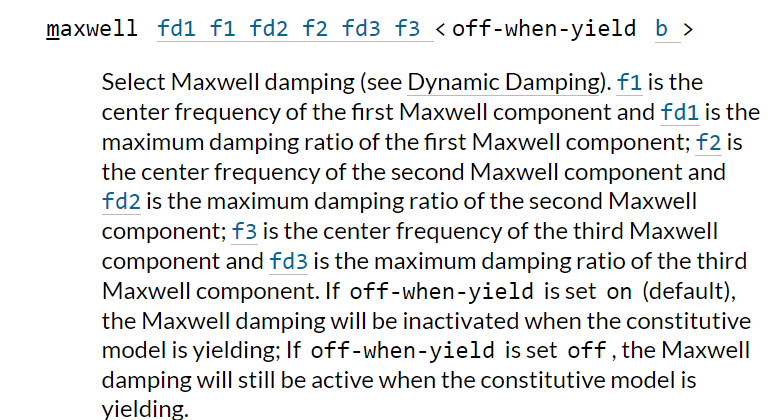

## Input

In [108]:
target_damping = 5.0 #-[%]
f_a = 0.1 # -[Hz]
f_b = 100 #-[Hz]
freq_band = np.logspace(np.log10(f_a), np.log10(f_b), num=100)

In [109]:
def get_single_maxwell_component(f_max: float, 
                                d_max: float, 
                                freq_maxwell: np.ndarray) -> np.ndarray:
    """Calculates the single frequency response from a maxwell component in a dynamic system

    Args:
        f_max (float): Frequency coresponding to the maximum damping ratio - [Hz]
        d_max (float): Maximum damping ratio. -[decimal] consistent with FLAC input
        freq_maxwell (np.ndarray): Array of frequencies for the Maxwell component. -[Hz]
    Returns:
        damping_maxwell (np.ndarray): Array of damping ratios corresponding to the frequencies. -[%]
    """
    alpha_k = 8 * d_max**2 + 4 * d_max * np.sqrt(2 * d_max**2 +1)
    tao_k = 1 / (2 * math.pi * f_max * np.sqrt(1 + alpha_k))
    print(alpha_k, tao_k)
    omega_maxwell = 2 * math.pi * freq_maxwell
    damping_maxwell = alpha_k * tao_k * omega_maxwell / ( 2 + 2*(1 + alpha_k) * tao_k**2 * omega_maxwell**2) * 100 # -[%]
    return damping_maxwell

0.22049937655763424 0.041160752538892294


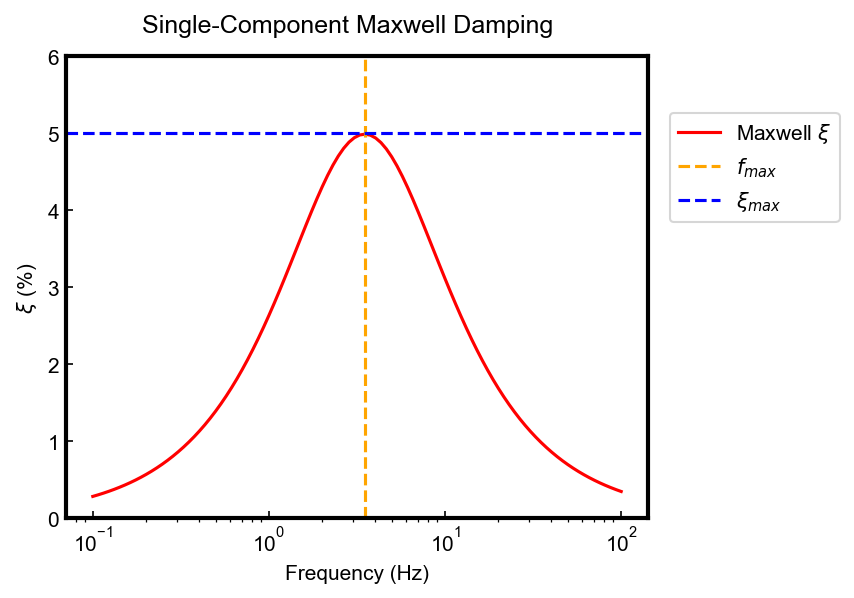

In [110]:
f = 3.5
d = 5.0/100.0
damping_maxwell = get_single_maxwell_component(f, d, freq_band)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
fig.suptitle('Single-Component Maxwell Damping', fontsize=12, y=0.95)
ax.semilogx(freq_band, damping_maxwell, color='red',label=r'Maxwell $\xi$')
ax.axvline(x=f, color='orange',ls='--',label='$f_{max}$')
ax.axhline(y=d*100, color='blue',ls='--',label=r'$\xi_{max}$')
ax.set_ylim(0, 6)
ax.set_ylabel(r'$\xi$ (%)')
ax.set_xlabel('Frequency (Hz)')
ax.tick_params(axis='both', direction='in')
ax.legend(bbox_to_anchor=(1.02, 0.9), loc='upper left')

In [111]:
def get_maxwell_real(d_max, f_max, freq_maxwell):
    alpha_k = 8 * d_max**2 + 4 * d_max * np.sqrt(2 * d_max**2 +1)
    tao_k = 1 / (2 * math.pi * f_max * np.sqrt(1 + alpha_k))
    omega_maxwell = 2 * math.pi * freq_maxwell
    print(alpha_k, tao_k)
    return alpha_k * tao_k**2*omega_maxwell**2 / (1 + tao_k**2*omega_maxwell**2)

def get_maxwell_imag(d_max, f_max, freq_maxwell):
    alpha_k = 8 * d_max**2 + 4 * d_max * np.sqrt(2 * d_max**2 +1)
    tao_k = 1 / (2 * math.pi * f_max * np.sqrt(1 + alpha_k))
    omega_maxwell = 2 * math.pi * freq_maxwell
    print(alpha_k, tao_k)
    return alpha_k * tao_k*omega_maxwell / (1 + tao_k**2*omega_maxwell**2)


def get_flac_maxwell(fd1: float, f1: float, 
                    fd2: float, f2: float, 
                    fd3: float, f3: float) -> np.ndarray:
    freq_band = np.logspace(-1, 2, num=200)
    
    fd_all= [fd1, fd2, fd3]
    f_all = [f1, f2, f3]
    max_real_sum = np.zeros_like(freq_band)
    max_imag_sum = np.zeros_like(freq_band)
    for freq, fd in zip(f_all, fd_all):
        max_real = get_maxwell_real(fd, freq, freq_band)
        max_imag = get_maxwell_imag(fd, freq, freq_band)
        max_real_sum = np.sum([max_real, max_real_sum], axis=0)
        max_imag_sum = np.sum([max_imag, max_imag_sum], axis=0)
    max_real_sum = 1 + max_real_sum
    damping_maxwell = max_imag_sum/max_real/2*100
    return damping_maxwell, freq_band


0.16608609757628473 0.29477104326480574
0.16608609757628473 0.29477104326480574
0.1431282972117468 0.04253090260421838
0.1431282972117468 0.04253090260421838
0.23019367364115584 0.0057397553076160195
0.23019367364115584 0.0057397553076160195


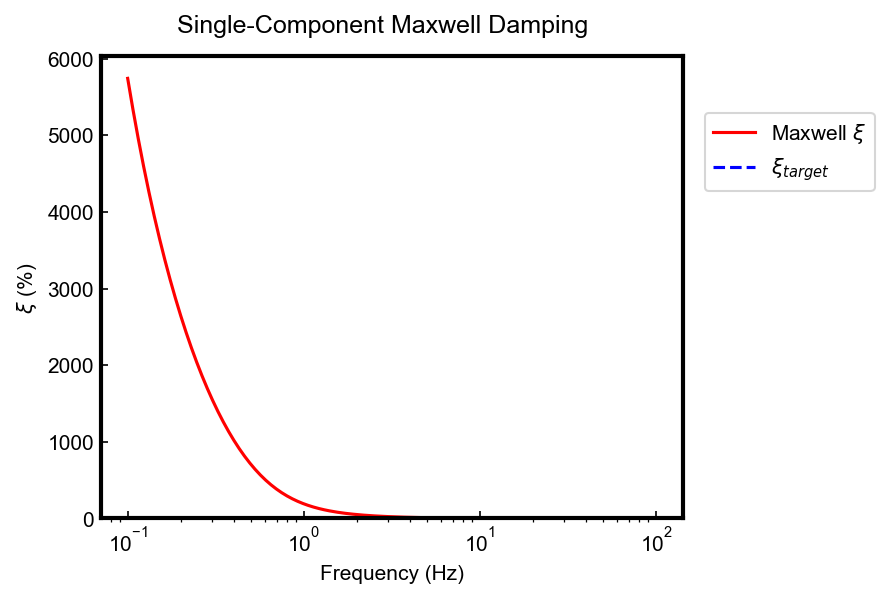

In [114]:
fd1 = 0.0385
f1 = 0.5
fd2 = 0.0335
f2 = 3.5
fd3 = 0.0520
f3 =25.0
target_damping = 5.0

damping_maxwell, freq_band = get_flac_maxwell(fd1, f1,fd2, f2, fd3, f3)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
fig.suptitle('Single-Component Maxwell Damping', fontsize=12, y=0.95)
ax.semilogx(freq_band, damping_maxwell, color='red',label=r'Maxwell $\xi$')

ax.axhline(y=target_damping, color='blue',ls='--',label=r'$\xi_{target}$')
ax.set_ylim(0, None)
ax.set_ylabel(r'$\xi$ (%)')
ax.set_xlabel('Frequency (Hz)')
ax.tick_params(axis='both', direction='in')
ax.legend(bbox_to_anchor=(1.02, 0.9), loc='upper left')